<a href="https://colab.research.google.com/github/gillilandrocque/EE8603_renegillilandrocque/blob/main/EE8603_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the first option for the final project for EE8603. My student number ends in 1 thus I am doing the chess classification task.

I will install the full version of pycaret as specified in the documentation


In [ ]:
pip install pycaret[full]


--2023-11-29 21:55:40--  https://archive.ics.uci.edu/static/public/22/chess+king+rook+vs+king+pawn.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘chess.zip’

chess.zip               [ <=>                ]  13.52K  --.-KB/s    in 0.04s   

2023-11-29 21:55:40 (353 KB/s) - ‘chess.zip’ saved [13844]

Archive:  chess.zip
     bkblk bknwy bkon8 bkona bkspr bkxbq bkxcr bkxwp blxwp bxqsq  ... spcop  \
0        f     f     f     f     f     f     f     f     f     f  ...     f   
1        f     f     f     f     t     f     f     f     f     f  ...     f   
2        f     f     f     f     t     f     t     f     f     f  ...     f   
3        f     f     f     f     f     f     f     f     t     f  ...     f   
4        f     f     f     f     f     f     f     f     f     f  ...     f   
...    ... 

,Description,Value
0,Session id,7328
1,Target,game_outcome
2,Target type,Binary
3,Target mapping,"nowin: 0, won: 1"
4,Original data shape,"(3196, 37)"
5,Transformed data shape,"(3196, 39)"
6,Transformed train set shape,"(2237, 39)"
7,Transformed test set shape,"(959, 39)"
8,Ordinal features,35
9,Categorical features,36


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9964,0.9992,0.9964,0.9965,0.9964,0.9928,0.9929,4.8600
lightgbm,Light Gradient Boosting Machine,0.9942,0.9996,0.9942,0.9942,0.9942,0.9884,0.9884,1.0430
xgboost,Extreme Gradient Boosting,0.9933,0.9996,0.9933,0.9934,0.9933,0.9866,0.9866,0.5380
dt,Decision Tree Classifier,0.9920,0.9919,0.9920,0.9920,0.9920,0.9839,0.9839,0.5280
et,Extra Trees Classifier,0.9911,0.9982,0.9911,0.9912,0.9911,0.9821,0.9822,0.9980
rf,Random Forest Classifier,0.9893,0.9984,0.9893,0.9894,0.9893,0.9785,0.9786,1.0410
gbc,Gradient Boosting Classifier,0.9776,0.9974,0.9776,0.9779,0.9776,0.9552,0.9555,1.0690
ada,Ada Boost Classifier,0.9620,0.9937,0.9620,0.9621,0.9620,0.9238,0.9239,0.7940
lr,Logistic Regression,0.9584,0.9927,0.9584,0.9585,0.9584,0.9167,0.9168,1.3490
svm,SVM - Linear Kernel,0.9580,0.0000,0.9580,0.9591,0.9580,0.9159,0.9170,0.6070


Processing:   0%|          | 0/71 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9911,1.0000,0.9911,0.9912,0.9911,0.9821,0.9823
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.9955,0.9993,0.9955,0.9956,0.9955,0.9911,0.9911
3,0.9955,0.9998,0.9955,0.9956,0.9955,0.9911,0.9911
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,0.9955,0.9978,0.9955,0.9956,0.9955,0.9911,0.9911
6,0.9911,0.9988,0.9911,0.9912,0.9911,0.9821,0.9823
7,0.9955,0.9994,0.9955,0.9956,0.9955,0.9910,0.9911
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


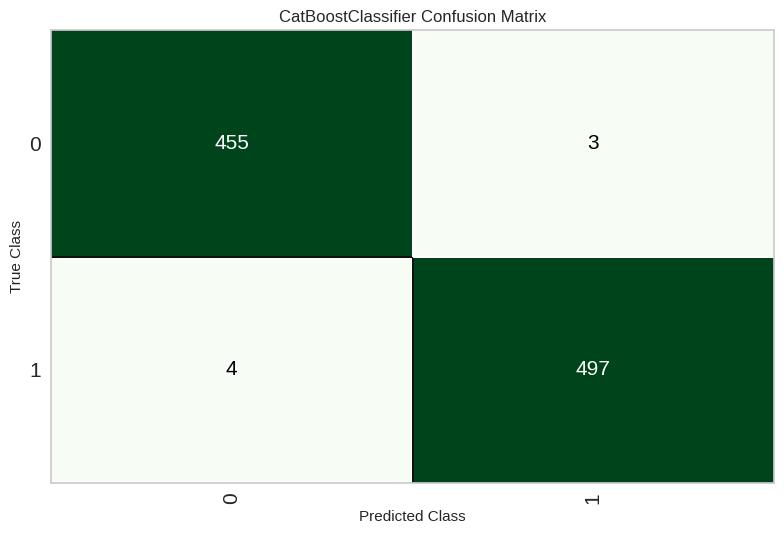

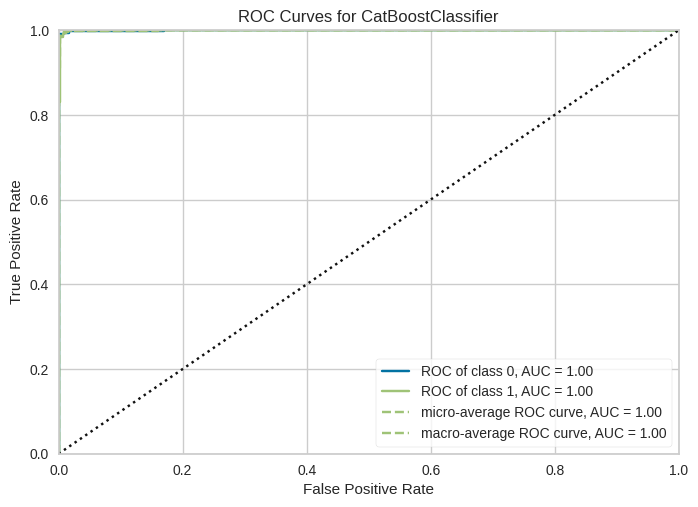

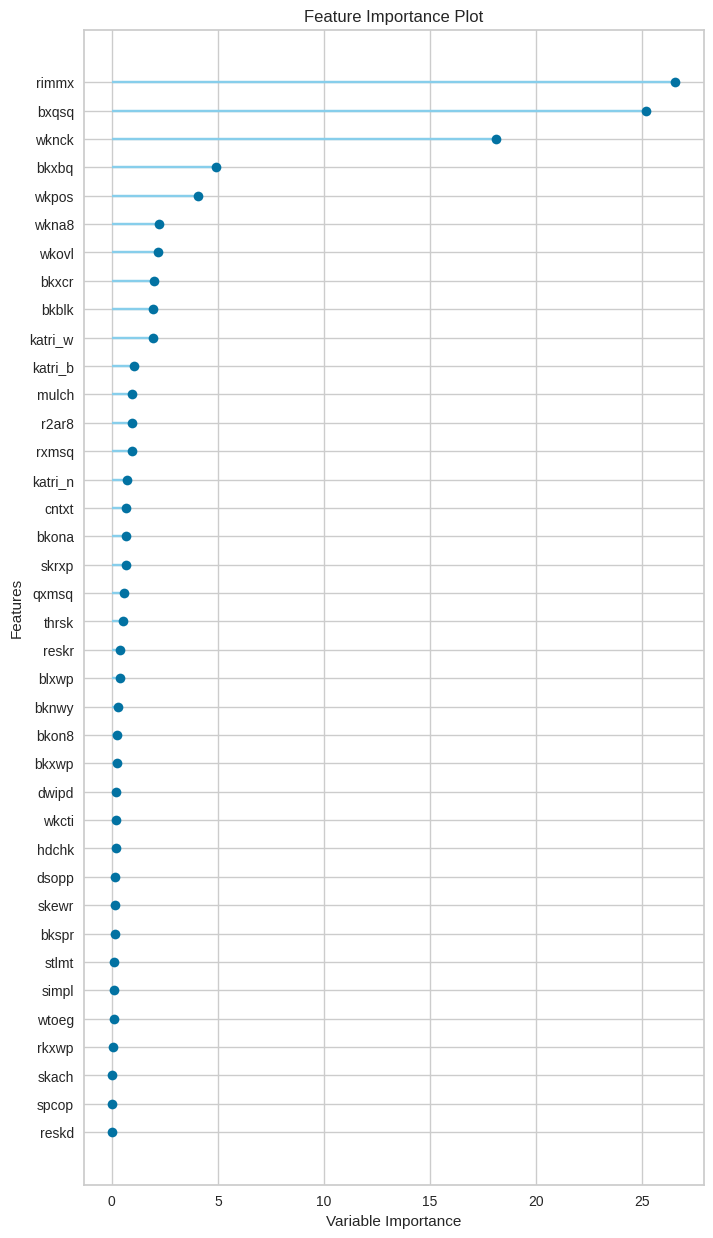

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.9927,0.9995,0.9927,0.9927,0.9927,0.9854,0.9854


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9911,0.9998,0.9911,0.9912,0.9911,0.9821,0.9823
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.9911,0.9989,0.9911,0.9911,0.9911,0.9821,0.9821
3,0.9911,0.9999,0.9911,0.9911,0.9911,0.9821,0.9821
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,0.9955,0.9988,0.9955,0.9956,0.9955,0.9911,0.9911
6,0.9911,0.9996,0.9911,0.9912,0.9911,0.9821,0.9823
7,0.9955,0.9999,0.9955,0.9956,0.9955,0.9910,0.9911
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9911,0.9999,0.9911,0.9912,0.9911,0.9821,0.9823
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.9911,0.9989,0.9911,0.9911,0.9911,0.9821,0.9821
3,0.9911,0.9998,0.9911,0.9911,0.9911,0.9821,0.9821
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,0.9955,0.9988,0.9955,0.9956,0.9955,0.9911,0.9911
6,0.9911,0.9995,0.9911,0.9912,0.9911,0.9821,0.9823
7,0.9955,0.9998,0.9955,0.9956,0.9955,0.9910,0.9911
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.9927,0.9997,0.9927,0.9927,0.9927,0.9854,0.9854


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9927,0.9997,0.9927,0.9927,0.9927,0.9854,0.9854


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None, include=[],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbo...
                                                                objective='binary:logistic', ...))],
    

In [42]:
import pandas as pd
from pycaret.classification import *

# import chess dataset and unzip the files, updating them if they don't exist
!wget https://archive.ics.uci.edu/static/public/22/chess+king+rook+vs+king+pawn.zip -O chess.zip
!unzip -u chess.zip

# the data is imported into a pandas data frame.

# By default there are no feature names, so the feature value list must be created.

# The feature value list is presented in kr-vs-kp.names, and describes the
#   state of the chess board via 36 attributes.

feature_value_list = ['bkblk','bknwy','bkon8','bkona','bkspr','bkxbq','bkxcr',
                      'bkxwp','blxwp','bxqsq','cntxt','dsopp','dwipd','hdchk',
                      'katri','mulch','qxmsq','r2ar8','reskd','reskr','rimmx',
                      'rkxwp','rxmsq','simpl','skach','skewr','skrxp','spcop',
                      'stlmt','thrsk','wkcti','wkna8','wknck','wkovl','wkpos',
                      'wtoeg', 'game_outcome']


chess_df = pd.read_csv("kr-vs-kp.data", names= feature_value_list)
print(chess_df)

# each attribute has a categorical value. To determine all the posisble values, a list is created to check the total number of categories
print('possible categories for each feature:')
char_seen = []
for i in range(len(feature_value_list)-1):
  for char in chess_df[feature_value_list[i]]:
    if char not in char_seen:
        char_seen.append(char)
print(''.join(char_seen))

# seeing as there are 4 categories possible, all of the data will be 1-hot-encoded by adding 6 sub attributes in place of the main attribute to form a boolean data representing the category.
# the categories for each attribute are either 'f', 't', 'l', 'g', 'n, 'w', or 'b'

# setup the experiment object with the chess data frame as the input data, and the game outcome as the target
experiment = ClassificationExperiment()
experiment.setup(chess_df, target= 'game_outcome')

# display transformed training data
experiment.get_config('X_train_transformed')

# compare models. This will compare all the models available in pycaret and return the model with the best metrics.
best_models = experiment.compare_models(sort= 'Accuracy', n_select= 3)
best_model = best_models[0]

# tuning the model hyperparameters for acccuracy
tuned_model = experiment.tune_model(best_model)

# these graphs display the metrics of the model. The confusion matrix, the area under the convergence curve, and a bar graph signifying the most important features.
experiment.plot_model(tuned_model, plot = 'confusion_matrix')
experiment.plot_model(tuned_model, plot = 'auc')
experiment.plot_model(tuned_model, plot = 'feature_all')

# using the results of this, we can drop the features with low importance if we so choose.

# now that the network is created and trained, we can use the best result from the model comparison to evaluate the test data that was withheld from the training during the test-train split
prediction_df = experiment.predict_model(best_model)

# blend top 3 models
experiment_blended = experiment.blend_models(best_models, )

# stack top 3 models
experiment_stacked = experiment.stack_models(best_models)

# predictions on the blended and stacked models
experiment_blended_predictions = experiment.predict_model(experiment_blended)
experiment_stacked_predictions = experiment.predict_model(experiment_stacked)

experiment.save_model(tuned_model, 'best_tuned_model')
experiment.save_model(experiment_blended, 'best_tuned_model')
experiment.save_model(experiment_stacked, 'best_tuned_model')

